In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.__version__

'2.3.0'

### 1)Linear Classifier for CIFAR10

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)
print('y_test: ',y_test.shape)
print('y_test[0]',y_test[0])

K = len(np.unique(y_train)) # Number of Classes
print('Number of classes: ',K)

x_train:  (50000, 32, 32, 3)
y_test:  (10000, 1)
y_test[0] [3]
Number of classes:  10


In [4]:
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10, 32x32x3=3072
# Din = 784 # MINIST

# Normalize pixel values: numpy works in one datatype(weights,features):float, faster training,
x_train, x_test = x_train / 255.0, x_test / 255.0


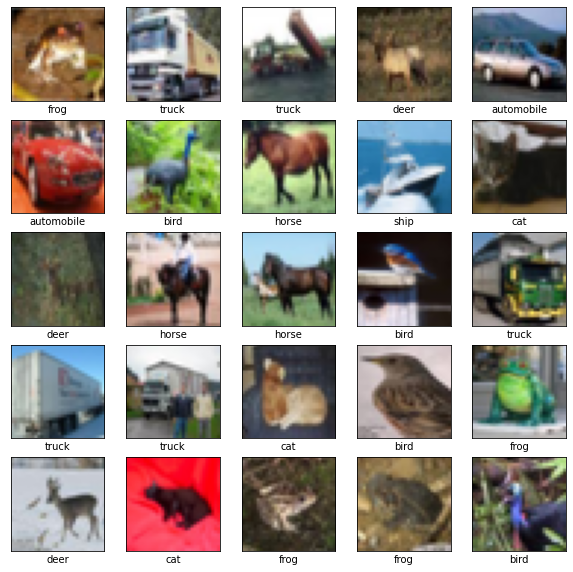

In [5]:
#verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [6]:
#centering the data and making range similar in order to get stable gradients
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#re-classify the y(label) sets as categorical: onehot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#resize x set into a collection of rows, each row is an image
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

y_train: (50000, 10)
y_test: (10000, 10)
x_train: (50000, 3072)
x_test: (10000, 3072)


In [7]:
#initialize the Weight matrix and bias 
std=1e-5
w1 = std*np.random.randn(Din, K)
b1 = np.zeros(K)
print("w1:", w1.shape)
print("b1:", b1.shape)

w1: (3072, 10)
b1: (10,)


In [8]:
#parameters
batch_size = Ntr    #set batchsize to entire trainingset size
iterations = 300
lr = 0.015         #learning rate
lr_decay= 0.9999   #learning rate decay
reg = 1e-7         #regularization parameter
loss_history = []
train_acc_history = []
val_acc_history = []

#fix seed for random number generator
seed = 0
rng = np.random.default_rng(seed=seed)

In [9]:
def accuracy(y_pred,y):
    predclass = np.argmax(y_pred,axis=1)
    realclass = np.argmax(y,axis=1)
    return ( np.sum(predclass==realclass)/realclass.size )

In [13]:
def reg_MSloss(y_pred,y,batchsize,reg,w1):
    return (1./batchsize)* np.square(y_pred-y).sum()  + reg*(np.sum(w1*w1))


In [16]:
def runlinearmodel(batchsize=batch_size,iterations=iterations,lr=lr,lr_decay=lr_decay,reg=reg):
    t0 = time.time()
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    loss_history = []
    test_losshistory = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        batch_indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(batch_indices)
        x = x_train[batch_indices]
        y = y_train[batch_indices]

        # Forward pass
        y_pred = x.dot(w1) + b1
        testy = x_test.dot(w1) + b1

        train_loss = reg_MSloss(y_pred,y,batch_size,reg,w1) #regularized mean square loss
        test_loss = reg_MSloss(testy,y_test,10000,reg,w1)
        loss_history.append(train_loss)
        test_losshistory.append(test_loss)

        train_acc= accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        val_acc=accuracy(testy,y_test)
        val_acc_history.append(val_acc)
        

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,val_acc))
        
        dy_pred = (1./batch_size)*2.0*(y_pred-y)
        dw1 = x.T.dot(dy_pred) + reg*w1
        db1 = dy_pred.sum(axis=0)

        # Backward pass
        w1 -= lr*dw1
        b1 -= lr*db1
        lr *= lr_decay

    t1 = time.time()
    print('time taken = ',(t1-t0))

    return w1,loss_history,test_losshistory,train_acc_history,val_acc_history


In [17]:

w1,loss_history,test_losshistory,train_acc_history,val_acc_history = runlinearmodel()

epoch 0/300: MSloss= 0.999985-- ,test loss= 0.999984--,train accracy= 0.123360--, test accracy= 0.121700
epoch 10/300: MSloss= 0.872596-- ,test loss= 0.872912--,train accracy= 0.360740--, test accracy= 0.353600
epoch 20/300: MSloss= 0.839026-- ,test loss= 0.838570--,train accracy= 0.372180--, test accracy= 0.373200
epoch 30/300: MSloss= 0.820187-- ,test loss= 0.820257--,train accracy= 0.385680--, test accracy= 0.383500
epoch 40/300: MSloss= 0.809934-- ,test loss= 0.809977--,train accracy= 0.390500--, test accracy= 0.387800
epoch 50/300: MSloss= 0.803414-- ,test loss= 0.803680--,train accracy= 0.391900--, test accracy= 0.388700
epoch 60/300: MSloss= 0.797943-- ,test loss= 0.799672--,train accracy= 0.398000--, test accracy= 0.391600
epoch 70/300: MSloss= 0.796537-- ,test loss= 0.797452--,train accracy= 0.394000--, test accracy= 0.394900
epoch 80/300: MSloss= 0.793764-- ,test loss= 0.795566--,train accracy= 0.400580--, test accracy= 0.396600
epoch 90/300: MSloss= 0.792151-- ,test loss= 0.

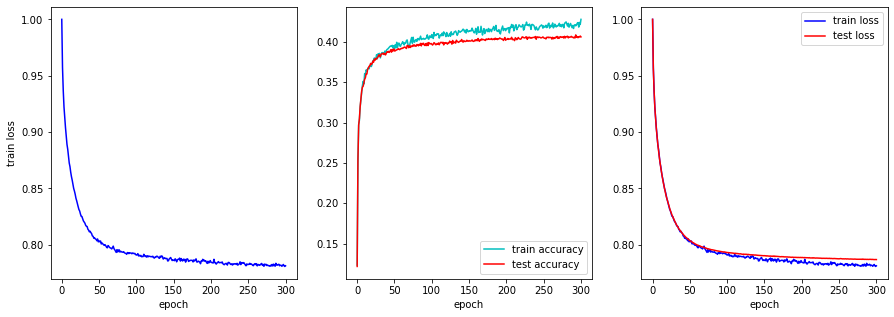

In [19]:
#display Train loss,train accuracy
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(loss_history,'b')
ax[0].set_xlabel('epoch') 
ax[0].set_ylabel('train loss') 

ax[1].plot(train_acc_history,'c')
ax[1].plot(val_acc_history,'r')
ax[1].set_xlabel('epoch') 
ax[1].legend(['train accuracy','test accuracy'])

ax[2].plot(loss_history,'b')
ax[2].plot(test_losshistory,'r')
ax[2].set_xlabel('epoch') 
ax[2].legend(['train loss','test loss']);

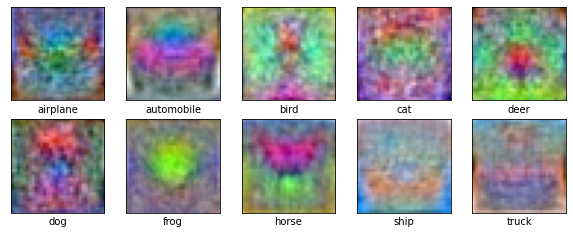

In [52]:
 # W is effectively 10 separate linear classifiers: one classifier per column of W 
 # Displaying w as images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    w = w1[:,i]
    wnorm = (w-min(w))/max(w) #+ mean_image.reshape(3072)
    wnorm = wnorm/max(wnorm)
    plt.imshow(wnorm.reshape((32,32,3)), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[i])
plt.show()


In [53]:
print(w1.shape)
w1_test = w1[:,1]
print(w1_test.shape)
print(w1_test[:20])

(3072, 10)
(3072,)
[-1.14981568e-03 -2.05741820e-03 -1.99972609e-03  4.24097793e-05
 -9.66574753e-04 -9.65271129e-04  6.81801674e-04 -3.06946726e-04
 -3.37090055e-04  2.32855653e-05 -1.21556360e-03 -1.16907994e-03
  6.28528901e-04 -4.66876415e-04 -8.35810566e-04 -2.36957442e-04
 -9.56876469e-04 -1.62778254e-03  2.21171394e-04 -9.16946154e-04]


[0.45350779 0.40835091 0.41122133 0.5128258  0.46262476 0.46268962
 0.54463812 0.49544391 0.49394416 0.5118743  0.45023657 0.45254932
 0.54198759 0.48748677 0.46913081 0.49892616 0.46310729 0.42972702
 0.52171991 0.46509399]


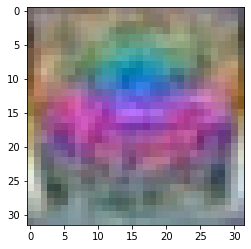

In [54]:
w1norm = (w1_test-min(w1_test))/max(w1_test)
w1norm = w1norm/max(w1norm)
print(w1norm[:20])
plt.figure(figsize=(4,4))
plt.imshow(w1norm.reshape((32,32,3)) )
plt.show()

In [59]:
checky = x_test.dot(w1) + b1
print ( (1./10000)* np.square(checky-y_test).sum()  + reg*(np.sum(w1*w1) ) )



0.8868145327277523
